In [43]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
import xgboost as xgb


In [44]:
# Replace the path as per your artifacts location
data = pd.read_csv("/home/abhishek/Desktop/IMF/src/modeling/cleaned_data_for_ml.csv")


In [45]:
from sklearn.preprocessing import LabelEncoder
import joblib

data["country"] = data["country"].astype(str)

le_country = LabelEncoder()
le_country.fit(data["country"])
joblib.dump(le_country, "/home/abhishek/Desktop/IMF/artifacts/le_country.pkl")


['/home/abhishek/Desktop/IMF/artifacts/le_country.pkl']

In [46]:
# Ensure string type and no missing values
data["country"] = data["country"].astype(str)

# Load or fit LabelEncoder
try:
    le_country = joblib.load("/home/abhishek/Desktop/IMF/artifacts/le_country.pkl")
except FileNotFoundError:
    le_country = LabelEncoder()
    le_country.fit(data["country"])
    joblib.dump(le_country, "/home/abhishek/Desktop/IMF/artifacts/le_country.pkl")

# Encode and store in a new column
data["country_encoded"] = le_country.transform(data["country"])


In [47]:
# Drop unused columns, ensure only numeric features
X = data.drop(columns=["country", "defaulted"], errors="ignore")
X["country_encoded"] = data["country_encoded"]
y = data["defaulted"]  # Use your final target column here

# Fill missing values if any
X = X.fillna(0)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [49]:
# Usually, you'll load an already trained XGBoost model
model = joblib.load("/home/abhishek/Desktop/IMF/artifacts/xgb_model.pkl")


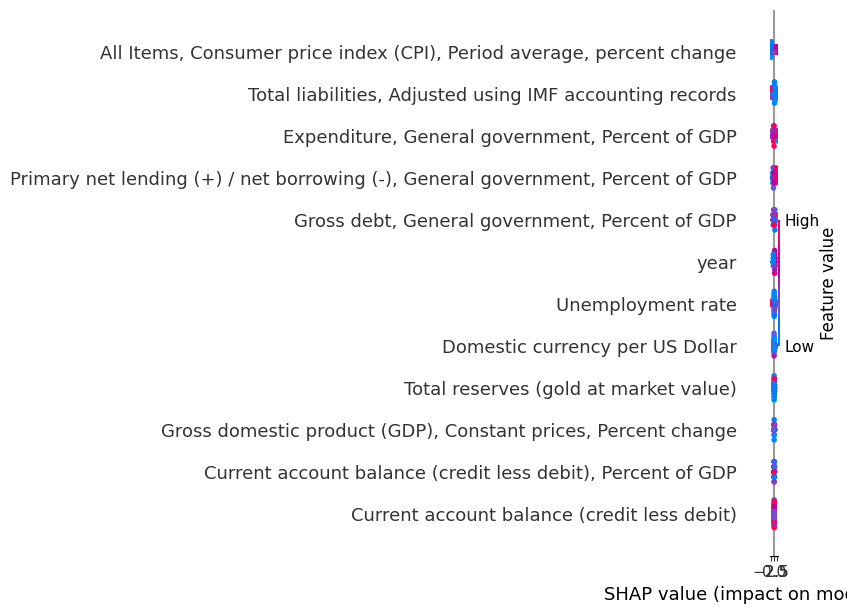

In [50]:
import shap

# Ensure feature order matches training
X_test = X_test[model.get_booster().feature_names]

explainer = shap.TreeExplainer(model)  # not .get_booster()
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


In [51]:
print(X_test.dtypes)
print(X_test.isnull().sum())


year                                                                               float64
All Items, Consumer price index (CPI), Period average, percent change              float64
Current account balance (credit less debit)                                        float64
Current account balance (credit less debit), Percent of GDP                        float64
Domestic currency per US Dollar                                                    float64
Expenditure, General government, Percent of GDP                                    float64
Gross debt, General government, Percent of GDP                                     float64
Gross domestic product (GDP), Constant prices, Percent change                      float64
Primary net lending (+) / net borrowing (-), General government, Percent of GDP    float64
Total liabilities, Adjusted using IMF accounting records                           float64
Total reserves (gold at market value)                                              float64

In [52]:
print(model.get_booster().feature_names)


['year', 'All Items, Consumer price index (CPI), Period average, percent change', 'Current account balance (credit less debit)', 'Current account balance (credit less debit), Percent of GDP', 'Domestic currency per US Dollar', 'Expenditure, General government, Percent of GDP', 'Gross debt, General government, Percent of GDP', 'Gross domestic product (GDP), Constant prices, Percent change', 'Primary net lending (+) / net borrowing (-), General government, Percent of GDP', 'Total liabilities, Adjusted using IMF accounting records', 'Total reserves (gold at market value)', 'Unemployment rate']


In [53]:
print(list(X_test.columns))


['year', 'All Items, Consumer price index (CPI), Period average, percent change', 'Current account balance (credit less debit)', 'Current account balance (credit less debit), Percent of GDP', 'Domestic currency per US Dollar', 'Expenditure, General government, Percent of GDP', 'Gross debt, General government, Percent of GDP', 'Gross domestic product (GDP), Constant prices, Percent change', 'Primary net lending (+) / net borrowing (-), General government, Percent of GDP', 'Total liabilities, Adjusted using IMF accounting records', 'Total reserves (gold at market value)', 'Unemployment rate']


In [54]:
sample_idx = 0  # ya koi bhi index tu choose kar
row = X_test.iloc[sample_idx]
shap_row = shap_values[sample_idx]

# Combine into dictionary
feature_importance = dict(zip(row.index, shap_row))

# Top 10 impactful features
important = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

# Create natural language-style summary
lines = []
for feat, val in important:
    direction = "increased" if val > 0 else "decreased"
    lines.append(f"- {feat} has {direction} the default risk (SHAP value: {val:.3f})")

shap_summary_text = "\n".join(lines)
print("🔍 SHAP Summary for LLM Prompt:")
print(shap_summary_text)


🔍 SHAP Summary for LLM Prompt:
- Expenditure, General government, Percent of GDP has increased the default risk (SHAP value: 2.514)
- All Items, Consumer price index (CPI), Period average, percent change has increased the default risk (SHAP value: 1.330)
- Gross debt, General government, Percent of GDP has increased the default risk (SHAP value: 0.591)
- Total liabilities, Adjusted using IMF accounting records has increased the default risk (SHAP value: 0.468)
- year has decreased the default risk (SHAP value: -0.448)
- Domestic currency per US Dollar has decreased the default risk (SHAP value: -0.246)
- Unemployment rate has increased the default risk (SHAP value: 0.210)
- Gross domestic product (GDP), Constant prices, Percent change has decreased the default risk (SHAP value: -0.128)
- Primary net lending (+) / net borrowing (-), General government, Percent of GDP has decreased the default risk (SHAP value: -0.102)
- Current account balance (credit less debit), Percent of GDP has dec

In [55]:
pip install transformers huggingface_hub


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [61]:
from transformers import pipeline

# Load flan-t5-small using text2text-generation
llm = pipeline("text2text-generation", model="google/flan-t5-small")

# Prepare your prompt (You can make this dynamic later)
prompt = "Give a sovereign risk analysis for south africa using past economic trends."

# Generate response
response = llm(prompt, max_new_tokens=300)
print(response[0]['generated_text'])


Device set to use cpu


Using past economic trends, a sovereign risk analysis for South Africa is needed.


In [60]:
# Predefined risk scores (based on default history & trends)
country_risk_score_map = {
    "India": 75,
    "Germany": 90,
    "Japan": 85,
    "Brazil": 50,
    "Myanmar": 40,
    "Sri Lanka": 30,
    "United States": 88,
    "South Africa": 60,
    "Italy": 65,
    "China": 80,
    "Russian Federation": 35,
    "United Kingdom": 87,
    "Bangladesh": 70,
    "Türkiye": 55,
    "France": 82
}

def get_risk_score(country_name):
    return country_risk_score_map.get(country_name, "Score not available")


In [62]:
import streamlit as st
from transformers import pipeline

# 1. Risk Score Mapping (manually define for now)
risk_scores = {
    "India": 78,
    "Germany": 91,
    "Argentina": 35,
    "Brazil": 60,
    "Sri Lanka": 30,
    "Japan": 85,
    "USA": 95,
    "Pakistan": 32,
    "Bangladesh": 50
}

# 2. Load LLM (use lightweight one like flan-t5-small)
@st.cache_resource
def load_model():
    return pipeline("text2text-generation", model="google/flan-t5-small")

llm = load_model()

# 3. Streamlit UI
st.title("🌍 Sovereign Risk Analyzer")

selected_country = st.selectbox("Select a Country", list(risk_scores.keys()))

if selected_country:
    score = risk_scores[selected_country]

    # 4. Prepare prompt for LLM
    prompt = f"Give a short sovereign risk investment explanation for {selected_country} with a risk score of {score}/100."

    # 5. Get LLM Response
    with st.spinner("Analyzing with LLM..."):
        llm_response = llm(prompt, max_length=100, do_sample=True)[0]["generated_text"]

    # 6. Show Output
    st.metric(label="Sovereign Risk Score", value=f"{score}/100")
    st.write("💬", llm_response)


2025-07-21 19:35:00.818 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 19:35:00.983 
  command:

    streamlit run /home/abhishek/Desktop/IMF/env/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-07-21 19:35:00.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 19:35:00.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 19:35:00.986 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 19:35:01.488 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 19:35:01.490 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 19:35:01.491 Thread 'Th